# Exploratory Data Analysis 
##         -- Children's Imagined Future and its association with socioeconomic status

## Background 

“Imagine you are now 25 years old. Write about the life you are leading, your interests, your home life and your work at the age of 25”. As a part of a longitudinal study on individuals born in 1958, over 10,000 11-year-old children in the UK were asked to write an essay given the instruction above (Center for Longitudinal Studies (CLS) | 1958 National Child Development Study). Their families’ demographic information, including socioeconomic status (SES) related items (e.g., father’s occupation), was recorded. At the age of 42, they participated in another sweep of the study, which collected information including their income range. 

One study examined this corpus and themes of children’s imagined future. With selected sample and a qualitative approach, it identified a wide range of themes, including marriage, family members, occupation, money, domestic life, vacations, leisure activities and animals. Although the children rarely described their future in terms of status, researchers discovered that high SES children are more likely to write about imaginations characterizing high-prestige lifestyles (e.g. large house, fancy vehicle and overseas vacation) (Elliott, 2010).

So far, no existing literature using this corpus has investigated this relationship of SES and children’s writing with a machine learning/NLP approach. Thus, I am here to fill the gap and discover new knowledge:). 

## Data 

We (my collaborator Dr. Holly Engstrom and I) obtained the longitudinal data at CLS' data access application portal. We first selected the age-11 and age-42 waves as our data, which contain information on:
1. children's essays
2. children's father's occupation
3. whether the family experienced financial hardship
4. weekly income at the age of 42.  

We had put enormous effort to clean and preprocess the data, including manually correcting all the misspellings in the essays. The data after processing is saved in full_data.csv under the **[current repository](https://github.com/h-karyn/ImaginedFutureAndSocioeconomics)**. 

## Data Overview    

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read data 
data_df = pd.read_csv('full_data.csv') 
data_df.shape

(18567, 13)

In [3]:
# get an overview of the top-n rows/samples
data_df.head()

,ID,file_name,original,corrected,misspellings,readable?,RA_name,completed?,word_count,father,mother,financial,pay_per_week
0,N10001N,B771-780,Today is my 25th birthday and I am in hospital...,Today is my 25th birthday and I am in hospital...,10.0,yes,Anika,yes,306.0,2.0,-1.0,2.0,237.25
1,N10002P,J1-10,The dog pounded up at me when i reached for he...,The dog pounded up at me when i reached for he...,9.0,yes,Andrea,yes,200.0,-1.0,-1.0,-1.0,NaN
2,N10003Q,J1-10,I would get married and be a swimming instruct...,I would get married and be a swimming instruct...,4.0,yes,Andrea,yes,268.0,3.0,6.0,1.0,NaN
3,N10004R,A821-830,When I am 25 years old. I hop that I will be m...,When I am 25 years old. I hope that I will be ...,23.0,yes,Manson,yes,169.0,2.0,8.0,2.0,221.25
4,N10005S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,6.0,2.0,NaN


## Data Cleaning

Since column file_name, original, misspellings, RA_name, completed?, word_count, and mother are not revalent to our analysis, I will drop those columns. 

In [4]:
# drop irrelevant columns
data_df = data_df.drop(['file_name', 'original', 'misspellings', 'word_count','RA_name', 'completed?', 'mother'], axis=1)
data_df.head(3)

,ID,corrected,readable?,father,financial,pay_per_week
0,N10001N,Today is my 25th birthday and I am in hospital...,yes,2.0,2.0,237.25
1,N10002P,The dog pounded up at me when i reached for he...,yes,-1.0,-1.0,NaN
2,N10003Q,I would get married and be a swimming instruct...,yes,3.0,1.0,NaN


In [5]:
# drop rows with missing values
data_df = data_df.dropna()

data_df.shape

(4843, 6)

Clean the 'readable?' column

In [6]:
# turn 'readable?' to lowercase
data_df['readable?'] = data_df['readable?'].str.lower()

# check the unique values
print(data_df['readable?'].unique())

# replace 'yexs' and 'yea' with 'yes'
data_df['readable?'] = data_df['readable?'].replace(['yexs', 'yea'], 'yes')

# check the unique values again
print(data_df['readable?'].unique())

# drop rows with 'no'
data_df = data_df[data_df['readable?'] == 'yes']

data_df.shape

['yes' 'no' 'yexs' 'yea']
['yes' 'no']


(4720, 6)

In [7]:
# preview the data
data_df.head(3) 

,ID,corrected,readable?,father,financial,pay_per_week
0,N10001N,Today is my 25th birthday and I am in hospital...,yes,2.0,2.0,237.25
3,N10004R,When I am 25 years old. I hope that I will be ...,yes,2.0,2.0,221.25
12,N10013S,Now that I am 25 and I have left college I thi...,yes,2.0,2.0,729.00


## Data Preprocessing

In this data set, we label high SES as 1 and low SES as 2: * father’s occupation is coded as: 1 - non-manual; 2 - manual; * financial hardship is coded as: 1 - No; 2 - Yes;

Combination of father’s occupation and financial hardship: * 1 - father had a non-manual job & no financial hardship. * 2 - father had a manual job & no financial hardship. * 3 - father had a non-manual job & financial hardship. * 4 - father had a manual job & financial hardship.

In [8]:
# Define a function to apply the conditions
def combine_columns(row):
    if row['father'] == 1 and row['financial'] == 1:
        return 1
    elif row['father'] == 2 and row['financial'] == 1:
        return 2
    elif row['father'] == 1 and row['financial'] == 2:
        return 3
    elif row['father'] == 2 and row['financial'] == 2:
        return 4
    else:
        return None 

In [9]:
# new NA values are created since not all rows values in father and financial follow the conditions
data_df = data_df.dropna()
data_df.shape

(4720, 6)

In [10]:
# Apply the function to each row
data_df['family_ses'] = data_df.apply(combine_columns, axis=1)

# Convert columns to categorical data type
data_df['father'] = data_df['father'].astype('category')
data_df['financial'] = data_df['financial'].astype('category')
data_df['family_ses'] = data_df['family_ses'].astype('category')

#preview the data
data_df.head(3)

,ID,corrected,readable?,father,financial,pay_per_week,family_ses
0,N10001N,Today is my 25th birthday and I am in hospital...,yes,2.0,2.0,237.25,4.0
3,N10004R,When I am 25 years old. I hope that I will be ...,yes,2.0,2.0,221.25,4.0
12,N10013S,Now that I am 25 and I have left college I thi...,yes,2.0,2.0,729.00,4.0


In [11]:
# check the datatype of each column
data_df.dtypes

ID                object
corrected         object
readable?         object
father          category
financial       category
pay_per_week     float64
family_ses      category
dtype: object

Let us check the distribution of the target variable `family_ses` and `income`.

In [12]:
# check the distribution of the target variable
data_df['family_ses'].value_counts()

family_ses
4.0    2204
3.0    1470
2.0     275
1.0      59
Name: count, dtype: int64

In [13]:
# check the distribution of pay_per_week
data_df['pay_per_week'].describe()

count     4720.000000
mean       519.020913
std       1597.513746
min          0.250000
25%        197.250000
50%        350.000000
75%        538.461538
max      61458.500000
Name: pay_per_week, dtype: float64

We notice that the income has a wide range (outliers on the right tail). We will discard the outliers that are 3 standard deviations away from the mean.

In [14]:
# remove outliers
data_df = data_df[data_df['pay_per_week'] < data_df['pay_per_week'].mean() + 3*data_df['pay_per_week'].std()]

print(data_df.shape)

(4696, 7)


In [15]:
# check the distribution of pay_per_week again
data_df['pay_per_week'].describe()

count    4696.000000
mean      439.817983
std       479.341075
min         0.250000
25%       195.750000
50%       349.125000
75%       530.000000
max      5308.000000
Name: pay_per_week, dtype: float64

<Axes: >

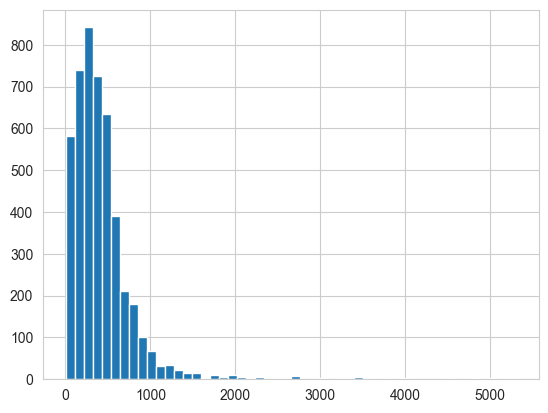

In [16]:
# let take a look at the distribution of pay_per_week
data_df['pay_per_week'].hist(bins=50)

Till this point, we have:

1. categorical variable `family_ses`, which will be the target variable for **supervised learning - classification**
2. numerical variable `income`, which will be the target variable for **supervised learning - regression**
3. text variable `essay`, which will used for **unsupervised learning - topic modeling**. Also, it will serve as the input for the supervised learning models.

Let us take another look at the data.

In [17]:
# check shape
print(data_df.shape)
# preview the data
data_df.head(3)

(4696, 7)


,ID,corrected,readable?,father,financial,pay_per_week,family_ses
0,N10001N,Today is my 25th birthday and I am in hospital...,yes,2.0,2.0,237.25,4.0
3,N10004R,When I am 25 years old. I hope that I will be ...,yes,2.0,2.0,221.25,4.0
12,N10013S,Now that I am 25 and I have left college I thi...,yes,2.0,2.0,729.00,4.0


In [18]:
# create a new dataframe with column corrected, family_ses and pay_per_week from data_df
df = data_df[['corrected', 'family_ses', 'pay_per_week']]

# preview the data
df.head(3)

,corrected,family_ses,pay_per_week
0,Today is my 25th birthday and I am in hospital...,4.0,237.25
3,When I am 25 years old. I hope that I will be ...,4.0,221.25
12,Now that I am 25 and I have left college I thi...,4.0,729.00


In [19]:
# save the dataframe to a new csv file
df.to_csv('cleaned_data.csv', index=False)

Next, we need to preprocess the text data.

## Text Preprocessing

For future classification and regression tasks, I will take an **embedding** approach using word2vec. I will use the `gensim` library to train the word2vec model.


Reference: 
- https://spotintelligence.com/2023/02/15/word2vec-for-text-classification/#Word2Vec_for_text_classification

In [20]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# apply the function to the 'corrected' column
df['essay'] = df['corrected'].apply(preprocess)

/var/folders/zh/79y5ykz51rxcnjchzb73nfxw0000gn/T/ipykernel_72874/889133808.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['essay'] = df['corrected'].apply(preprocess)


In [21]:
from gensim.models import Word2Vec

sentences = [sentence.split() for sentence in df['essay']]
w2v_model = Word2Vec(sentences, window=5, min_count=5, workers=4)

In [22]:
import numpy as np

def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [23]:
essays = np.array([vectorize(sentence) for sentence in df['essay']])

In [24]:
# preview essays
essays[:3]

array([[-2.25361764e-01,  2.62811154e-01,  1.13309413e-01,
        -1.53241992e-01, -4.49879244e-02, -7.71004111e-02,
         3.07783127e-01,  6.02508008e-01, -1.67315662e-01,
        -1.92314684e-01,  1.20013632e-01, -3.01180691e-01,
         1.43110961e-01, -6.64033964e-02,  3.38556394e-02,
        -3.42258126e-01,  4.06566352e-01, -4.82220888e-01,
        -2.79698163e-01, -7.21583426e-01, -1.04887903e-01,
         2.43179306e-01, -3.56257588e-01, -2.70024031e-01,
        -1.62293583e-01, -1.22696303e-01,  1.30371764e-01,
        -2.47618198e-01, -3.70857716e-01, -1.55908568e-02,
         3.20075005e-01, -2.92620450e-01,  5.05863950e-02,
        -2.30930999e-01, -2.85560787e-01,  2.41886437e-01,
         2.56357849e-01, -5.16456246e-01, -1.37954757e-01,
        -3.54355872e-01, -4.52492237e-02, -8.58089030e-02,
         1.77981481e-01, -9.11854580e-02,  1.22150727e-01,
        -9.77069065e-02, -9.47081596e-02,  2.28215858e-01,
        -1.66618317e-01,  4.83938754e-01,  2.77357623e-0

In [25]:
# put essays back to df
df['essay_vec'] = list(essays)

# preview the data
df.head(3)

/var/folders/zh/79y5ykz51rxcnjchzb73nfxw0000gn/T/ipykernel_72874/208592734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['essay_vec'] = list(essays)


,corrected,family_ses,pay_per_week,essay,essay_vec
0,Today is my 25th birthday and I am in hospital...,4.0,237.25,today 25th birthday hospital first baby child ...,"[-0.22536176, 0.26281115, 0.11330941, -0.15324..."
3,When I am 25 years old. I hope that I will be ...,4.0,221.25,25 years old hope married raising family would...,"[-0.08755729, 0.19815509, 0.24926771, 0.226038..."
12,Now that I am 25 and I have left college I thi...,4.0,729.00,25 left college think go ask interview fire st...,"[0.052956723, 0.39143288, 0.17867592, 0.057318..."


# Modelling 

In the following sections, I will build a classification model to predict the family_ses and a regression model to predict the income.

## Classification Model

In [26]:
# check the distribution of the target variable
df['family_ses'].value_counts()

family_ses
4.0    2195
3.0    1459
2.0     275
1.0      58
Name: count, dtype: int64

In [27]:
y

NameError: name 'y' is not defined

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# split the data
X = np.array(list(df['essay_vec']))
y = np.array(df['family_ses'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# build the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# make predictions
y_pred = clf.predict(X_test)

# evaluate the model
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:', classification_report(y_test, y_pred))
print('Confusion Matrix:', confusion_matrix(y_test, y_pred))
